# Create a Neural Network for the Pendulum Swing-Up Problem

By training a NN, create a controller which can perform a pendulum swing-up.

<img src="Images/pendulum.png" width="200">

In [2]:
import tensorflow
from tensorflow import keras
import os
import numpy as np

In [3]:
nfe = 150
total_time = 3.0
dt = total_time/nfe

In [4]:
# Numpy saved array format:
#     [qx, qy, qthb, qthlt, qthlb, dqx, dqy, dqthb, dqthlt, dqthlb, vx, hm, tauh, tauk]

th_ar = np.array([])
dth_ar = np.array([])
ddth_ar = np.array([])
Tc_ar = np.array([])

filebase = os.getcwd()
filepath = filebase + r'\\Datasets\\pendulum_no_disturbance\\'
print("Directory: ", filepath)

files_loaded = 0

for file in os.listdir(filepath):
    filename = os.fsdecode(file)
    if filename.endswith(".npy"):  # import all stored values
        fileall = os.path.join(filepath, filename)
        # print("Filename: ", filename)
        th, dth, ddth, Tc = np.load(fileall, allow_pickle = True)
        
        th_ar = np.append(th_ar, th[3:]) # remove first 3 collocation points (redundent)
        dth_ar = np.append(dth_ar, dth[3:])
        ddth_ar = np.append(ddth_ar, ddth[3:])
        Tc_ar = np.append(Tc_ar, Tc[1:]) # remove first collocation point (redundent)
        
        files_loaded+=1

    else:
        continue

print("-------------------------------------------------------------------------------------------")
print("Done.")
print("Files Loaded:", files_loaded)
print("-------------------------------------------------------------------------------------------")

Directory:  C:\Users\Nick\Google Drive\PythonPrograms\machine_learning_projects\Control_Problems\\Datasets\\pendulum_no_disturbance\\
-------------------------------------------------------------------------------------------
Done.
Files Loaded: 1000
-------------------------------------------------------------------------------------------


In [5]:
print(th_ar[2::3].shape) # only use mesh points
print(Tc_ar.shape)

(149000,)
(149000,)


In [6]:
# Segment data into training and test data
train_seg = 0.9 # test = 0.1
test_seg = 1.0-train_seg

# Training data
th_train = th_ar[2::3][0:int(train_seg*files_loaded*(nfe-1))]
dth_train = dth_ar[2::3][0:int(train_seg*files_loaded*(nfe-1))]
ddth_train = ddth_ar[2::3][0:int(train_seg*files_loaded*(nfe-1))]
Tc_train = Tc_ar[0:int(train_seg*files_loaded*(nfe-1))]

# Test data
th_test = th_ar[2::3][int(train_seg*files_loaded*(nfe-1)):]
dth_test = dth_ar[2::3][int(train_seg*files_loaded*(nfe-1)):]
ddth_test = ddth_ar[2::3][int(train_seg*files_loaded*(nfe-1)):]
Tc_test = Tc_ar[int(train_seg*files_loaded*(nfe-1)):]


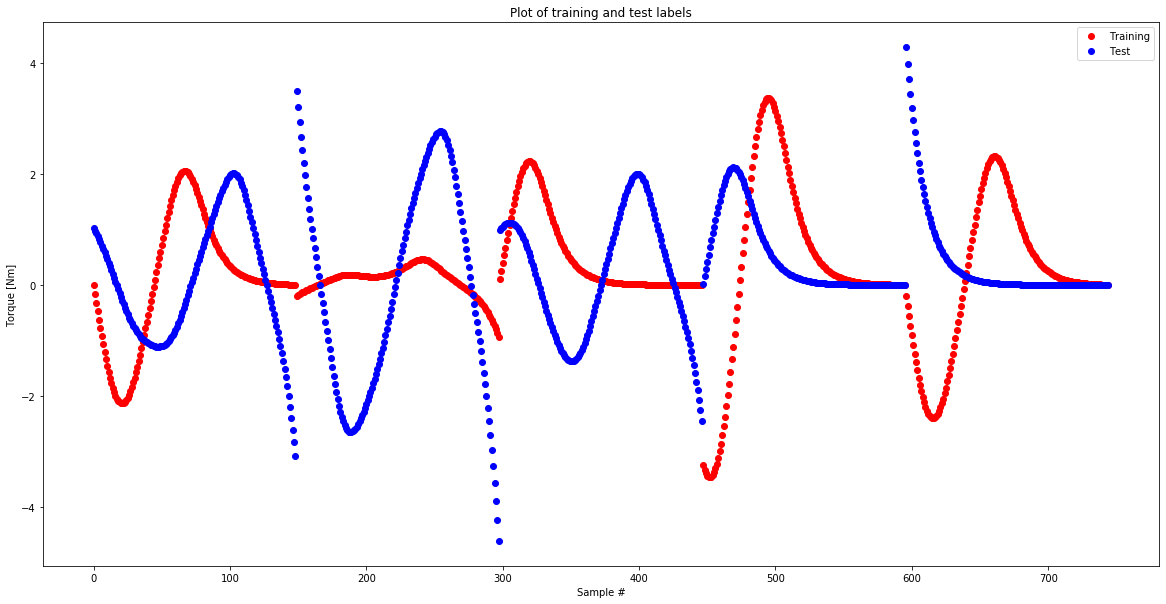

In [7]:
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(Tc_train[0:5*(nfe-1)], 'ro')
ax.plot(Tc_test[0:5*(nfe-1)], 'bo')

ax.set(xlabel='Sample #', ylabel='Torque [Nm]',
       title='Plot of training and test labels');

ax.legend(["Training", "Test"]);

In [8]:
print(th_train.shape) # only use mesh points
print(Tc_train.shape) 
print(th_test.shape)
print(Tc_test.shape)

(134100,)
(134100,)
(14900,)
(14900,)


In [9]:
# reformat training data and label data
train_data = np.stack((th_train, dth_train, ddth_train), axis = 1) # combine arrays to training data
train_data = np.reshape(train_data,(train_data.shape[0],train_data.shape[1],1)) # Reshape training data
train_labels = np.reshape(Tc_train,(Tc_train.shape[0], 1)) # combine torques to make training labels 

test_data = np.stack((th_test, dth_test, ddth_test), axis = 1) # combine arrays to test data
test_data = np.reshape(test_data,(test_data.shape[0],test_data.shape[1],1)) # Reshape test data
test_labels = np.reshape(Tc_test,(Tc_test.shape[0], 1)) # combine torques to make test labels 

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(134100, 3, 1)
(134100, 1)
(14900, 3, 1)
(14900, 1)


In [10]:
# Create Model

input_size = train_data.shape[1] # number of inputs to NN
output_size = train_labels.shape[1] # numer of outputs of NN

model = keras.Sequential([
        keras.layers.Flatten(input_shape=(input_size, 1)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(output_size)
    ])

model.compile(optimizer='adam', loss='mean_squared_error',)

In [11]:
# help(model.fit)

In [12]:
# hist = model.fit(train_data, train_labels, epochs=10, validation_split=0.1, batch_size=nfe-1) # train the model

validation_data = (test_data, test_labels)

hist = model.fit(train_data, train_labels, epochs=10, validation_data=validation_data, batch_size=nfe-1) # train the model

Train on 134100 samples, validate on 14900 samples
Epoch 1/10
134100/134100 [==============================] - 5s 36us/sample - loss: 0.2162 - val_loss: 0.0335
Epoch 2/10
134100/134100 [==============================] - 7s 50us/sample - loss: 0.0234 - val_loss: 0.0106
Epoch 3/10
134100/134100 [==============================] - 8s 59us/sample - loss: 0.0153 - val_loss: 0.0165
Epoch 4/10
134100/134100 [==============================] - 8s 58us/sample - loss: 0.0110 - val_loss: 0.0169
Epoch 5/10
134100/134100 [==============================] - 4s 32us/sample - loss: 0.0135 - val_loss: 0.0087
Epoch 6/10
134100/134100 [==============================] - 7s 56us/sample - loss: 0.0093 - val_loss: 0.0090
Epoch 7/10
134100/134100 [==============================] - 8s 56us/sample - loss: 0.0103 - val_loss: 0.0141
Epoch 8/10
134100/134100 [==============================] - 8s 56us/sample - loss: 0.0094 - val_loss: 0.0050
Epoch 9/10
134100/134100 [==============================] - 5s 37us/sample - 

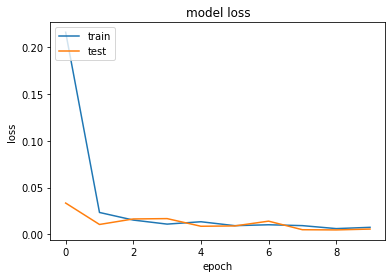

In [15]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

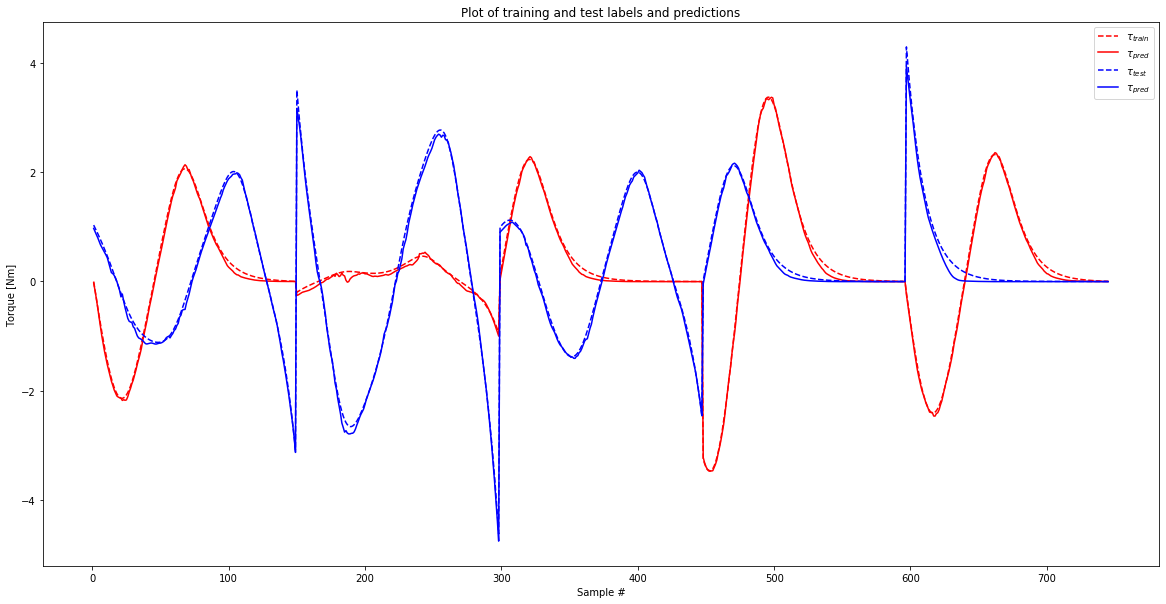

In [16]:
import matplotlib
import matplotlib.pyplot as plt

train_predictions = model.predict(train_data)
n_train = np.linspace(1, len(train_predictions), len(train_predictions))

test_predictions = model.predict(test_data)
n_test = np.linspace(1, len(test_predictions), len(test_predictions))

no_batches = 5*(nfe-1)

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(n_train[0:no_batches], train_labels[0:no_batches,0], 'r--')
ax.plot(n_train[0:no_batches], train_predictions[0:no_batches,0], 'r-')
ax.plot(n_test[0:no_batches], test_labels[0:no_batches,0], 'b--')
ax.plot(n_test[0:no_batches], test_predictions[0:no_batches,0], 'b-')

ax.set(xlabel='Sample #', ylabel='Torque [Nm]',
       title='Plot of training and test labels and predictions');

ax.legend(["$\\tau_{train}$", "$\\tau_{pred}$","$\\tau_{test}$", "$\\tau_{pred}$"]);


## Forward Simulation

Now that we have trained a NN to act as a controller, a forward simulation of the system can be computed.

In [17]:
import pendulum, utils, numpy as np
from importlib import reload
import sympy as sym
reload(pendulum)

th = sym.symbols('\\theta_0')
dth  = sym.symbols('\\dot{\\theta_0}')
ddth = sym.symbols('\\ddot{\\theta_0}')
Tc = sym.symbols('T_c0')


angles = 'abs'  # 'abs' or 'rel'
num_links = 1   # for these tests, from 2 to 8

# EOM = pendulum.get_N_link_EOM(num_links=num_links, angles=angles, lambdify=True)
_, EOM = pendulum.get_N_link_EOM(num_links=num_links, angles=angles, lambdify=False)
EOM[0] = EOM[0].simplify()

# Solve equation for ddth
EOM_solve_ddth = sym.solve(EOM,ddth)[ddth]
EOM_solve_ddth

In [18]:
# [q, Tc]
EOM_lam = sym.lambdify([th, Tc], EOM_solve_ddth)

In [26]:
import random

# number of simulation steps
N = nfe

# Initialize state and control arrays
ddth_sim = np.zeros(N)
dth_sim = np.zeros(N)
th_sim = np.zeros(N)
Tc_sim = np.zeros(N)

# Create a random starting state
th_sim_0 = random.uniform(-np.pi, np.pi)
dth_sim_0 = random.uniform(-0.1, 0.1)
Tc_sim_0 = 0.0
ddth_sim_0 = EOM_lam(th_sim_0, Tc_sim_0)

ddth_sim[0] = ddth_sim_0
dth_sim[0] = dth_sim_0
th_sim[0] = th_sim_0
Tc_sim[0] = Tc_sim_0

# Forward simulation
for i in range(1,N):
    state = np.array([th_sim[i-1], dth_sim[i-1], ddth_sim[i-1]])
    Tc_sim[i-1] = model.predict(np.reshape(state, (1,state.shape[0],1)))[0,0]
    
    ddth_sim[i] = EOM_lam(th_sim[i-1],Tc_sim[i-1])
    dth_sim[i] = dth_sim[i-1] + dt*ddth_sim[i]
    th_sim[i] = th_sim[i-1] + dt*dth_sim[i]


In [32]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

def plot_robot(i,th_in,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1.5,1.5])
    ax.set_ylim([-1.5,1.5])
    
    #plot pole
    botx = 0.0
    boty = 0.0
    topx = np.sin(th_in[i])
    topy = -np.cos(th_in[i])
    ax.plot([botx, topx],[boty, topy], 'black')
    
update = lambda i: plot_robot(i,th_sim,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1, update, frames=nfe,interval=1000*dt,repeat_delay=1000)
plt.close(animate._fig)

display(HTML(animate.to_html5_video())) #you need to convert the animation to HTML5 to embed it in the notebook
